# CHAPTER 18 - Learning 

### George Tzanetakis, University of Victoria 


## WORKPLAN 

The section number is based on the 3th edition of the AIMA textbook and is the suggested
reading for this week. Each list entry provides just the additional sections. For example the Expected reading include the sections listed under Basic as well as the sections listed under Expected. Some additional readings are suggested for Advanced. 

1. Basic: Sections **18.1**, **18.2**, and **Summary**
2. Expected: Same as Basic plus **18.3**, **18.6**, **18.7**
3. Advanced: All the chapter including bibligraphical and historical notes 






# Forms of learning  

An agent is **learning** if it improves its performance on future tasks after making observations about the world. 
In this chapter, we focus on a simple type of learning problem which is given a collection of input-output pairs, learn 
a function that predicts the output for new inputs. Even though at first glance this seems like a simple learning problem 
it has a large number of applications. 

## Feedback to learn from 

There are *types of feedback* that determine the three main types of learning: 

* **Unsupervised learning:** the agent learns patterns in the input without any explicit feedback. The most common example of unsuprvised learning is **clustering**
* **Reinforcement learning:** the agent learns from a series of reinforcements (rewards and punishments).
* **Supervised learning:** the agent observes some example input/output pairs and learns a function that maps the input to output. 




In [3]:
import numpy as np
mu = 3.0 
sigma = 0.2 
s = np.random.normal(mu, sigma, 10)
print(s)

[2.87730851 3.03342278 3.03367002 3.30130075 3.49475262 2.87601533
 2.8124366  3.23201194 2.82079448 3.10311373]


In [4]:
samples = np.random.normal(mu, sigma, 10000)


## Simple Naive Bayes binary classification example

In this notebook I will show a very simple example of this idea. Hopefully this will give you some general intuition about this approach. Then you can review the specific book examples that are more complicated (learning Gaussian mixtures, Bayesian networks with hidden variables, and learning hmm parameters). We will end by showing the general mathematical notation. 



Let's consider a simple binary classification problem with one continous attribute. For example this could be classifying whether some one is a professional basketball player or not based on their height. We can generate some synthetic data for this problem by simply sampling two Gaussian distribution. Let's say that professional basketball players have an average height of 190cm and the average height of other people is 175cm. For simiplicity we will consider they both have a standard deviation of 10cm. 

In [5]:
import numpy as np

# generate twenty samples of each class 
bball_samples = np.random.normal(190, 10, 20)
other_samples = np.random.normal(175, 10, 20)
print(bball_samples)
print(other_samples)

[199.75968195 189.92646826 170.58953612 184.79353926 167.70288742
 204.15053178 180.35451204 186.32696733 195.07197518 191.74084877
 170.61860955 198.2611092  170.76314257 179.69196607 194.55363215
 197.20220132 203.30462549 202.69946957 206.08307046 203.82237005]
[159.60989321 172.5329254  180.2067365  178.14166257 172.52732566
 163.04047212 159.05407217 179.20246609 152.56537927 189.45078765
 179.84704358 173.01565692 169.30023166 167.24402415 182.37192164
 162.59358627 169.70705759 175.48461213 168.42411359 191.00937401]


In [6]:
# generate 1000 samples of each class and plot histogram 

bball_mean_height = 190 
other_mean_height = 175 
bball_samples = np.random.normal(bball_mean_height, 10, 1000)
other_samples = np.random.normal(other_mean_height, 10, 1000)

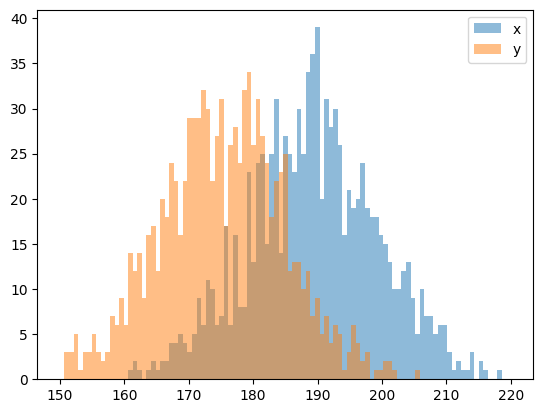

In [7]:
from matplotlib import pyplot
bins = np.linspace(150, 220, 100)

pyplot.hist(bball_samples, bins, alpha=0.5, label='x')
pyplot.hist(other_samples, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

You can clearly see in the histogram the height-distribution and overlap. You can also see that there is an equal number of instances for each class and that the standard deviation is the same.

Now suppose that you are just given the nba_samples and other_samples and told that these are labeled samples for training a Naive Bayes classifier. You also know that they both have a standard deviation of 10cm so we will keep that. In this case the only parameter we are trying to estimate is the mean of each class. So 𝜃=(𝜇𝑛𝑏𝑎,𝜇𝑜𝑡ℎ𝑒𝑟).

Given this data the maximum-likelihood estimate for the means is easily obtained by taking the statistical mean of the samples.

In [8]:
mu_bball = np.mean(bball_samples)
mu_other = np.mean(other_samples)
print(mu_bball, mu_other)

189.3937109842116 175.0417562092532


Now that we have "learned" a model we can use it to predict. Suppose you are given a test height - lets say 183cm. You can calcuate the $P(183/nba)$ and $P(183/other)$ by using the corresponding probability density functions characterized by $\mu_{nba}$ and $\sigma = 10$ and $\mu_{other}$ and $\sigma = 10$. 

In [9]:
from scipy.stats import norm

test_height = 183

p_bball = norm(mu_bball, 10).pdf(test_height)
p_other = norm(mu_other, 10).pdf(test_height)
print(p_bball, p_other)

if (p_bball > p_other): 
    print(str(test_height) + " is more likely a professional basketball player")
else: 
    print(str(test_height) + " is more likely NOT a professional basketball player")


0.03251930626980593 0.029065835062969926
183 is more likely a professional basketball player


## Learning Decision Trees 




A **decision tree** represents a function that takes as input a vector of attribute values and return a **decision** - a single output value. The input and output values can be discrete or continuous. To make things simple we will focus initially on discrete attributes and a single binary output (true or false)(positive or negative). 

A decision tree makes a decision by performing a sequence of test. Each node in the tree corresponds to a test of the value of one of the input attributes $A_i$ and the branches from the node are labeled with the possible values of the attribute. Each leaf node in the tree specifies a value to be return by the function. 

One way to think of a decision tree is as through propositional logic. The goal attribute is true if and only if the input attributes satisfy one of the paths leading to a leaf with value *true*: 

$$
Goal <=> (Path_{1} \lor Path_{2} \lor \dots)
$$

Each path is a conjuction of attribute-value tests required to follow the path. 

## Inducing decision trees from examples


An instance or example that can be used to "train" a decision tree consists of an $(\bf{x},y)$ pair, where $x$ is a vector of values for the input attributes, and $y$ is a single output value. This is called the target (or goal) attribute and corresponds to whether $WillWait$ is $true$ or $false$. 

<img src="images/decision_tree_attributes.png" width="100%"/>


<img src="images/decision_tree.png" width="100%"/>


Ideally we would want the smallest possible tree that is consistent with the examples. However, this is an intractable problem as there are $2^{2^{n}}$ trees to consider. We can do a decent job using a greedy divide and conquer strategy. 

1. Choose a "good" attribute to split
2. If all examples after a split are positive (or negative) then return the corresponding classification 
3. Create two subproblems based on the split
4. Recursively repeat the process until there are no attributes left to split 
5. When there are are both positive and negative examples use plurality to make decision


<img src="images/decision_tree_attribute_splits.png" width="100%"/>

<img src="images/decision_tree_learning_algorithm.png" width="100%"/>

<img src="images/induced_decision_tree.png" width="100%"/>


## Choosing attribute tests

We need a formal measure of "fairly good" and "really useless" to implement the $IMPORTANCE$ function. We will use the notation of information gain, which is defined in term of **entropy**, the fundamental quantity in information theory. 

**Entropy** of random variable: 

$$ 
H(V) = \sum_{k} P(v_k) \log_{2} \frac{1}{P(v_k)} = - \sum_{k} P(v_k) \log_2P(v_k)
$$

For example the entropy of a fair coin is 1 bit: 
$$
H(Fair) = -(0.5 \log_2 0.5 + 0.5 \log_2 0.5) = 1
$$

If *Loaded* is a random coin with $0.99$ probability of being Head and $0.01$ probability of being tail we get: 

$$
H(Loaded) = -(0.99 \log_2 0.98 + 0.01 \log_2 0.01) \approx 0.08 bits
$$

Let's definte $B(q)$ as the entropy of a Boolean random variable that is true with probability $q$: 
$$
B(q) = -\left (q \log_2 q + (1-q) \log_2 (1 - q)\right)
$$

If the training set contains $p$ positive examples and $n$ negative examples then the entropy of the target attribute on the whole set is: 
$$ 
H(Goal) = B\left(\frac{p}{p+n}\right)
$$

For example the restaurant training set has $p=n=6$ so the corresponding entropy is $B(0.5) = 1$. A test on a single attribute(feature) might give us only part of this 1 bit. We can measure exactly how much by looking at the entropy remaining after the attribute test. 
Suppose that an attribute A with $d$ distinct values divides the training set $E$ into subset $E_1, \dots E_d$. Each subset $E_k$ has $p_k$ positive examples and $n_k$ negative examples so if we go along that branch we need an additional $B(p_k/(p_k +n_k)$ bits of information to answer the question. A randomly chosen example from the training set has the kth value for the attribute with probability $(p_k + n_k)/(p + n)$, so the expected entropy remaining after testing attribute $A$ is 
$$ 
Remainder(A) = \sum_{k=1}^{d} \frac{(p_k + n_k)}{p+n} B\left(\frac{p_k}{p_k+n_k}\right)
$$

The **information gain** from the attribute test on $A$ is expected reduction in entropy: 
$$ 
Gain(A) = B\left(\frac{p}{p+n}\right) - Remainder(A) 
$$

For example consider the attributes from our example we have: 

$$ 
Gain(Patrons) = 1 - \left[\frac{2}{12} B\left(\frac{0}{2}\right) + \frac{4}{12}B\left(\frac{4}{4}\right)+ \frac{6}{12}B\left(\frac{2}{6}\right)\right] \approx 0.541 bits
$$
$$ 
Gain(Type) = 1 - \left[\frac{2}{12} B\left(\frac{1}{2}\right) + \frac{2}{12}B\left(\frac{1}{2}\right)+ \frac{4}{12}B\left(\frac{2}{4}\right) + \frac{4}{12}B\left(\frac{2}{4}\right)\right] = 0  bits
$$


### Additional topics 

* Overfitting
* Decision tree pruning
* Signficance test
* Early stopping
* Missing data
* Multi-valued attributes
* Continuous and integer-valued input attributes
* Continuous-valued output attributes

One **important property** of decision trees is that it is possible for a human to understand the reason for the output of the learning algorithm. This can be a **legal requirement** for financial decisions and is not the case in other learned representations such as neural networks. 